# Algoritmo KNN para classificação de Peças de LEGO!

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time

from threading import Thread
from threading import Lock

import multiprocessing

from sklearn.model_selection import train_test_split 

from src.Images import preprocess_images_from_dir
from src.Images import get_all_images_path
from src.Images import read_processed_image
from src.Images import plot_image
from src.Images import flatten_to_image

from src.Distances import euclidean_distance
from src.Distances import cosine_distance

from src.Knn import Knn

from src.Settings import *

from src.Parallel import thread_classify_function
from src.Parallel import split_data_into_chunks
from src.Parallel import presentation_thread_classify_function

print_all_settings()

USE_NUMPY_ARRAY: False
N_ROWS: 32
N_COLUMNS: 32
PREPROCESS_IMAGES: False
N_THREADS: 4
N_TESTS_USED: 100
WORKSPACE: .
DATASET_DIR: ./dataset
IMAGES_DIR: ./dataset/dataset
PROCESSED_IMAGES_PATH: ./dataset/dataset/_processed


## Preprocessamento das imagens

In [2]:
if GlobalSettings.PREPROCESS_IMAGES:
    ans = input("Are you sure you want to preprocess all images? [type 'yes']")
    if ans == "yes":
        preprocess_images_from_dir(
            dir_path=GlobalSettings.IMAGES_DIR, n_rows=GlobalSettings.N_ROWS,
            n_columns=GlobalSettings.N_COLUMNS, extension="png"
        )

## Paths para as imagens preprocessadas

In [3]:
images_path = get_all_images_path(GlobalSettings.PROCESSED_IMAGES_PATH)
images_path[:3]

['./dataset/dataset/_processed/14719 flat tile corner 2x2 000L.png',
 './dataset/dataset/_processed/14719 flat tile corner 2x2 000R.png',
 './dataset/dataset/_processed/14719 flat tile corner 2x2 001L.png']

## Organizando os dados

In [4]:
data = [
    (
        int(path.split(" ")[0].split("/")[-1]),
        read_processed_image(path, GlobalSettings.N_ROWS, GlobalSettings.N_COLUMNS).flatten()
    ) for path in images_path
] if GlobalSettings.USE_NUMPY_ARRAY else [
    (
        int(path.split(" ")[0].split("/")[-1]),
        list(read_processed_image(path, GlobalSettings.N_ROWS, GlobalSettings.N_COLUMNS).flatten())
    ) for path in images_path
]


y, x = zip(*data)
x = list(x)
y = list(y)

## Divisão em treino e teste

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

## Treinando o modelo (adicionando os elementos conhecidos)

In [6]:
knn = Knn()

knn.add_points(list(zip(y_train, x_train)))

28000 points were added!


28000

## Demonstração de imagem preprocessada

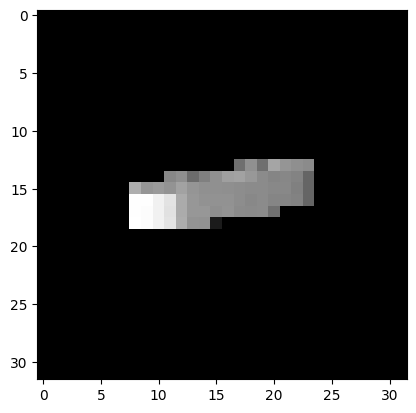

In [7]:
plot_image(flatten_to_image(x_train[0], GlobalSettings.N_ROWS, GlobalSettings.N_COLUMNS))

## Classificando conjunto de teste

### Python nativo X Numpy Array

Como foi solicitado para o trabalho, para fazer o algoritmo Knn, não usamos bibliotecas que implementam tal classificação. Porém, devido a velocidade de processamento, optamos por demonstrar em exemplos menores a equivalencia dos resultados do algoritmo usando listas do Python e arrays do Numpy (é gritante a diferença).

### Explicação

Para começar, após o preprocessamento das imagens e a separação dos dados em conjuntos de treino e teste terem sido feito, a execução do algoritmo consiste em, dado um dado do conjunto de testes, informar para o algoritmo o vetor que representa a imagem desconhecida e então, a partir dela e de todas as imagens que o computador conhece, calcular a distância, usando uma métrica informada, para todos as imagens e usar as $N$ primeiras para determinar a possível classificação da imagem teste. No caso desse trabalho específico, foi solicitado $N=1$ sempre.

Para o algoritmo de Knn funcionar precisamos determinar uma métrica a ser usada. Nesse trabalho foram usadas "duas métricas", sendo a primeira a distância euclidiana e a segunda, que não é exatamente uma métrica, a disância cosseno.

A distância euclidiana é calculada usando a função:
``` Python
def euclidean_distance(point_a: list, point_b: list) -> float:
    if GlobalSettings.USE_NUMPY_ARRAY:
        return np.linalg.norm(point_a-point_b)
    else:
        if len(point_a) != len(point_b) or len(point_a) < 2:
            return -1
    
        sum = 0
        for i in range(len(point_a)):
            sum += (point_a[i] - point_b[i]) ** 2
    
        return sqrt(sum)
```
Note que ela possui um desvio condicional baseado em um atributo chamado USE_NUMPY_ARRAY, que como o nome sugere, define se vai usar o método `np.linalg.norm` ou o modo manual para calcular. Dado os pontos $X=(x_1,x_2,\dots,x_n)$ e $Y=(y_1,y_2,\dots,y_n)$, a distancia euclidiana é definida como: 
$$\sqrt{\sum_{i=1}^{n} (x_i-y_i)^2}$$

Já a distância cosseno, que não é exatamente uma métrica, é definida como:
$$\frac{\sum_{i=1}^{n} x_iy_i}{\sqrt{\sum_{i=1}^{n} x_i^2} \cdot \sqrt{\sum_{i=1}^{n} y_i^2}}$$

Em código, ela fica da seguinte forma:

``` Python
def dot_product(point_a: list, point_b: list) -> float:
    if len(point_a) != len(point_b) or len(point_a) < 2:
        return -1

    sum = 0
    for i in range(len(point_a)):
        sum += point_a[i] * point_b[i]

    return sum

def cosine_distance(point_a: list, point_b: list) -> float:
    if GlobalSettings.USE_NUMPY_ARRAY:
        return 1 - (
            (np.dot(point_a,point_b))
            / (np.sqrt(np.dot(point_a,point_a)) * np.sqrt(np.dot(point_b, point_b)))
        )
    else:
        if len(point_a) != len(point_b) or len(point_a) < 2:
            return -1
    
        return 1 - (
            (dot_product(point_a, point_b))
            / (sqrt(dot_product(point_a, point_a)) * sqrt(dot_product(point_b, point_b)))
        )

```

Note novamente o desvio condicional para usar ou não os arrays do Numpy.

### Execução

Primeiramente vamos executar a execução do algoritmo usando apenas os 100 primeiros testes apenas para validação da implementação.

O programa usará multiprocessamento e as listas nativas do python.

In [8]:
file_lock = Lock()
results_lock = Lock()

total_correct = multiprocessing.Value('i', 0)
total_wrong = multiprocessing.Value('i', 0)
tests_to_be_used = 100

test_data = list(zip(x_test[:tests_to_be_used], y_test[:tests_to_be_used]))
total_tests = len(test_data)

chunks = split_data_into_chunks(test_data, GlobalSettings.N_THREADS)

total_execution_start = time.time()

threads = []

for i, chunk in enumerate(chunks):
    thread = multiprocessing.Process(
        target=presentation_thread_classify_function,
        args=(file_lock, results_lock, knn, chunk, total_correct, total_wrong),
        name=f"Thread {i}"
    )
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(f"Tempo total de todo o processo: {time.time()-total_execution_start}s")

print(f"{total_correct.value}/{total_tests} respostas corretas ({total_correct.value/total_tests*100}%)")
print(f"{total_wrong.value}/{total_tests} respostas erradas ({total_wrong.value/total_tests*100}%)")

Alguns resultados:
Certo: 4274; Respondido: 4274; Acertou: True; Tempo de processamento: 7.382457733154297s
Certo: 3070; Respondido: 3069; Acertou: False; Tempo de processamento: 7.32975172996521s
Certo: 27925; Respondido: 27925; Acertou: True; Tempo de processamento: 7.513664960861206s

Tempo de execução Thread 3: 216.2150104045868s

Alguns resultados:
Certo: 4286; Respondido: 3623; Acertou: False; Tempo de processamento: 7.466490030288696s
Certo: 3039; Respondido: 3045; Acertou: False; Tempo de processamento: 7.42849326133728s
Certo: 3700; Respondido: 85984; Acertou: False; Tempo de processamento: 7.446035385131836s

Tempo de execução Thread 0: 216.5107831954956s

Alguns resultados:
Certo: 3001; Respondido: 3001; Acertou: True; Tempo de processamento: 7.691523790359497s
Certo: 3020; Respondido: 3039; Acertou: False; Tempo de processamento: 7.42374324798584s
Certo: 3068; Respondido: 33909; Acertou: False; Tempo de processamento: 7.654798269271851s

Tempo de execução Thread 2: 217.3762

--------------------------------
Agora vamos repetir o mesmo processo, porém usando os arrays da biblioteca Numpy.

Note que zeramos os valores de acertos e erros, além de definir a variável `USE_NUMPY_ARRAY` para verdadeiro.

In [9]:
GlobalSettings.USE_NUMPY_ARRAY = True
total_correct.value = 0
total_wrong.value = 0

print(f"{total_correct.value}/{total_tests} respostas corretas ({total_correct.value/total_tests*100}%)")
print(f"{total_wrong.value}/{total_tests} respostas erradas ({total_wrong.value/total_tests*100}%)")

data = [
    (
        int(path.split(" ")[0].split("/")[-1]),
        read_processed_image(path, GlobalSettings.N_ROWS, GlobalSettings.N_COLUMNS).flatten()
    ) for path in images_path
] 

y, x = zip(*data)
x = list(x)
y = list(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

knn.clear()

knn.add_points(list(zip(y_train, x_train)))

0/100 respostas corretas (0.0%)
0/100 respostas erradas (0.0%)
28000 points were added!


28000

In [10]:
tests_to_be_used = 100
total_correct.value = 0
total_wrong.value = 0

test_data = list(zip(x_test[:tests_to_be_used], y_test[:tests_to_be_used]))
total_tests = len(test_data)

chunks = split_data_into_chunks(test_data, GlobalSettings.N_THREADS)

total_execution_start = time.time()

threads = []

for i, chunk in enumerate(chunks):
    thread = multiprocessing.Process(
        target=presentation_thread_classify_function,
        args=(file_lock, results_lock, knn, chunk, total_correct, total_wrong),
        name=f"Thread {i}"
    )
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(f"Tempo total de todo o processo: {time.time()-total_execution_start}s")

print(f"{total_correct.value}/{total_tests} respostas corretas ({total_correct.value/total_tests*100}%)")
print(f"{total_wrong.value}/{total_tests} respostas erradas ({total_wrong.value/total_tests*100}%)")

Alguns resultados:
Certo: 4286; Respondido: 3623; Acertou: False; Tempo de processamento: 0.1757955551147461s
Certo: 3039; Respondido: 3045; Acertou: False; Tempo de processamento: 0.15875244140625s
Certo: 3700; Respondido: 85984; Acertou: False; Tempo de processamento: 0.15701532363891602s

Tempo de execução Thread 0: 4.020031452178955s

Alguns resultados:
Certo: 3001; Respondido: 3001; Acertou: True; Tempo de processamento: 0.18378734588623047s
Certo: 3020; Respondido: 3039; Acertou: False; Tempo de processamento: 0.15672659873962402s
Certo: 3068; Respondido: 33909; Acertou: False; Tempo de processamento: 0.15659737586975098s

Tempo de execução Thread 2: 4.014650344848633s

Alguns resultados:
Certo: 4274; Respondido: 4274; Acertou: True; Tempo de processamento: 0.18352556228637695s
Certo: 3070; Respondido: 3069; Acertou: False; Tempo de processamento: 0.15662670135498047s
Certo: 27925; Respondido: 27925; Acertou: True; Tempo de processamento: 0.15530085563659668s

Tempo de execução T

Como é possível de observar, o tempo de processamento caiu de cerca de 200 segundos, usando as listas nativas do python, para menos de 4 segundos usando os arrays do Numpy, isso considerando que não usamos nem 1% dos dados de teste (100/12000). 

Além de observar o tempo de execução, podemos notar que o resultado é exatamente o mesmo, o que significa que nossa implementação está correta. Portanto, com objetivo de mostrar os resultados obtidos para mais casos de teste, vamos usar o Numpy daqui em diante.

## Teste distância euclidiana (3000 testes)

In [11]:
GlobalSettings.LOG_FILE_NAME = "3000_distancia_euclidiana.csv"
tests_to_be_used = 3000
total_correct.value = 0
total_wrong.value = 0

test_data = list(zip(x_test[:tests_to_be_used], y_test[:tests_to_be_used]))
total_tests = len(test_data)

chunks = split_data_into_chunks(test_data, GlobalSettings.N_THREADS)

total_execution_start = time.time()

threads = []

for i, chunk in enumerate(chunks):
    thread = multiprocessing.Process(
        target=presentation_thread_classify_function,
        args=(file_lock, results_lock, knn, chunk, total_correct, total_wrong),
        name=f"Thread {i}"
    )
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(f"Tempo total de todo o processo: {time.time()-total_execution_start}s")

print(f"{total_correct.value}/{total_tests} respostas corretas ({total_correct.value/total_tests*100}%)")
print(f"{total_wrong.value}/{total_tests} respostas erradas ({total_wrong.value/total_tests*100}%)")

Alguns resultados:
Certo: 3002; Respondido: 3002; Acertou: True; Tempo de processamento: 0.18437504768371582s
Certo: 41678; Respondido: 3700; Acertou: False; Tempo de processamento: 0.1558983325958252s
Certo: 6143; Respondido: 6143; Acertou: True; Tempo de processamento: 0.15538358688354492s

Tempo de execução Thread 1: 126.15400576591492s

Alguns resultados:
Certo: 3005; Respondido: 3005; Acertou: True; Tempo de processamento: 0.18725848197937012s
Certo: 4150; Respondido: 4150; Acertou: True; Tempo de processamento: 0.15790438652038574s
Certo: 54200; Respondido: 3024; Acertou: False; Tempo de processamento: 0.15829968452453613s

Tempo de execução Thread 2: 127.09284448623657s

Alguns resultados:
Certo: 4286; Respondido: 3623; Acertou: False; Tempo de processamento: 0.18506503105163574s
Certo: 3039; Respondido: 3045; Acertou: False; Tempo de processamento: 0.16111516952514648s
Certo: 3700; Respondido: 85984; Acertou: False; Tempo de processamento: 0.16130328178405762s

Tempo de execuçã

## Teste distância cosseno (3000 testes)

In [13]:
GlobalSettings.LOG_FILE_NAME = "3000_distancia_cosseno.csv"
tests_to_be_used = 3000
total_correct.value = 0
total_wrong.value = 0

test_data = list(zip(x_test[:tests_to_be_used], y_test[:tests_to_be_used]))
total_tests = len(test_data)

chunks = split_data_into_chunks(test_data, GlobalSettings.N_THREADS)

total_execution_start = time.time()

threads = []

for i, chunk in enumerate(chunks):
    thread = multiprocessing.Process(
        target=presentation_thread_classify_function,
        args=(file_lock, results_lock, knn, chunk, total_correct, total_wrong, cosine_distance),
        name=f"Thread {i}"
    )
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(f"Tempo total de todo o processo: {time.time()-total_execution_start}s")

print(f"{total_correct.value}/{total_tests} respostas corretas ({total_correct.value/total_tests*100}%)")
print(f"{total_wrong.value}/{total_tests} respostas erradas ({total_wrong.value/total_tests*100}%)")

Alguns resultados:
Certo: 3002; Respondido: 3002; Acertou: True; Tempo de processamento: 0.24074268341064453s
Certo: 41678; Respondido: 3040; Acertou: False; Tempo de processamento: 0.2104034423828125s
Certo: 6143; Respondido: 6143; Acertou: True; Tempo de processamento: 0.2130730152130127s

Tempo de execução Thread 1: 190.48474025726318s

Alguns resultados:
Certo: 85984; Respondido: 3023; Acertou: False; Tempo de processamento: 0.24415946006774902s
Certo: 3298; Respondido: 3298; Acertou: True; Tempo de processamento: 0.21785902976989746s
Certo: 3062; Respondido: 3062; Acertou: True; Tempo de processamento: 0.21058869361877441s

Tempo de execução Thread 3: 192.81206345558167s

Alguns resultados:
Certo: 3005; Respondido: 3005; Acertou: True; Tempo de processamento: 0.24324250221252441s
Certo: 4150; Respondido: 4150; Acertou: True; Tempo de processamento: 0.20711493492126465s
Certo: 54200; Respondido: 3024; Acertou: False; Tempo de processamento: 0.20903921127319336s

Tempo de execução T

## Teste distância euclidiana (6000 testes)

In [14]:
GlobalSettings.LOG_FILE_NAME = "6000_distancia_euclidiana.csv"
tests_to_be_used = 6000
total_correct.value = 0
total_wrong.value = 0

test_data = list(zip(x_test[:tests_to_be_used], y_test[:tests_to_be_used]))
total_tests = len(test_data)

chunks = split_data_into_chunks(test_data, GlobalSettings.N_THREADS)

total_execution_start = time.time()

threads = []

for i, chunk in enumerate(chunks):
    thread = multiprocessing.Process(
        target=presentation_thread_classify_function,
        args=(file_lock, results_lock, knn, chunk, total_correct, total_wrong),
        name=f"Thread {i}"
    )
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(f"Tempo total de todo o processo: {time.time()-total_execution_start}s")

print(f"{total_correct.value}/{total_tests} respostas corretas ({total_correct.value/total_tests*100}%)")
print(f"{total_wrong.value}/{total_tests} respostas erradas ({total_wrong.value/total_tests*100}%)")

Alguns resultados:
Certo: 3046; Respondido: 3003; Acertou: False; Tempo de processamento: 0.18693089485168457s
Certo: 3004; Respondido: 6143; Acertou: False; Tempo de processamento: 0.1571817398071289s
Certo: 4274; Respondido: 4274; Acertou: True; Tempo de processamento: 0.16055989265441895s

Tempo de execução Thread 2: 283.64205861091614s

Alguns resultados:
Certo: 4490; Respondido: 3700; Acertou: False; Tempo de processamento: 0.18185806274414062s
Certo: 3659; Respondido: 3659; Acertou: True; Tempo de processamento: 0.15401053428649902s
Certo: 4274; Respondido: 4274; Acertou: True; Tempo de processamento: 0.15552139282226562s

Tempo de execução Thread 3: 284.4121947288513s

Alguns resultados:
Certo: 4286; Respondido: 3623; Acertou: False; Tempo de processamento: 0.1861889362335205s
Certo: 3039; Respondido: 3045; Acertou: False; Tempo de processamento: 0.16106915473937988s
Certo: 3700; Respondido: 85984; Acertou: False; Tempo de processamento: 0.1606767177581787s

Tempo de execução Th

## Teste distância cosseno (6000 testes)

In [15]:
GlobalSettings.LOG_FILE_NAME = "6000_distancia_cosseno.csv"
tests_to_be_used = 6000
total_correct.value = 0
total_wrong.value = 0

test_data = list(zip(x_test[:tests_to_be_used], y_test[:tests_to_be_used]))
total_tests = len(test_data)

chunks = split_data_into_chunks(test_data, GlobalSettings.N_THREADS)

total_execution_start = time.time()

threads = []

for i, chunk in enumerate(chunks):
    thread = multiprocessing.Process(
        target=presentation_thread_classify_function,
        args=(file_lock, results_lock, knn, chunk, total_correct, total_wrong, cosine_distance),
        name=f"Thread {i}"
    )
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(f"Tempo total de todo o processo: {time.time()-total_execution_start}s")

print(f"{total_correct.value}/{total_tests} respostas corretas ({total_correct.value/total_tests*100}%)")
print(f"{total_wrong.value}/{total_tests} respostas erradas ({total_wrong.value/total_tests*100}%)")

Alguns resultados:
Certo: 3046; Respondido: 3003; Acertou: False; Tempo de processamento: 0.30788516998291016s
Certo: 3004; Respondido: 6143; Acertou: False; Tempo de processamento: 0.2747924327850342s
Certo: 4274; Respondido: 4274; Acertou: True; Tempo de processamento: 0.27287936210632324s

Tempo de execução Thread 2: 404.32582998275757s

Alguns resultados:
Certo: 4490; Respondido: 3700; Acertou: False; Tempo de processamento: 0.31470274925231934s
Certo: 3659; Respondido: 3659; Acertou: True; Tempo de processamento: 0.2682507038116455s
Certo: 4274; Respondido: 4274; Acertou: True; Tempo de processamento: 0.2641115188598633s

Tempo de execução Thread 3: 409.65589118003845s

Alguns resultados:
Certo: 4286; Respondido: 3623; Acertou: False; Tempo de processamento: 0.3170814514160156s
Certo: 3039; Respondido: 3045; Acertou: False; Tempo de processamento: 0.2831301689147949s
Certo: 3700; Respondido: 85984; Acertou: False; Tempo de processamento: 0.26642441749572754s

Tempo de execução Thr

## Teste distância euclidiana (12000 testes)

In [16]:
GlobalSettings.LOG_FILE_NAME = "12000_distancia_euclidiana.csv"
tests_to_be_used = 12000
total_correct.value = 0
total_wrong.value = 0

test_data = list(zip(x_test[:tests_to_be_used], y_test[:tests_to_be_used]))
total_tests = len(test_data)

chunks = split_data_into_chunks(test_data, GlobalSettings.N_THREADS)

total_execution_start = time.time()

threads = []

for i, chunk in enumerate(chunks):
    thread = multiprocessing.Process(
        target=presentation_thread_classify_function,
        args=(file_lock, results_lock, knn, chunk, total_correct, total_wrong),
        name=f"Thread {i}"
    )
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(f"Tempo total de todo o processo: {time.time()-total_execution_start}s")

print(f"{total_correct.value}/{total_tests} respostas corretas ({total_correct.value/total_tests*100}%)")
print(f"{total_wrong.value}/{total_tests} respostas erradas ({total_wrong.value/total_tests*100}%)")

Alguns resultados:
Certo: 3069; Respondido: 3069; Acertou: True; Tempo de processamento: 0.13878154754638672s
Certo: 3020; Respondido: 3020; Acertou: True; Tempo de processamento: 0.11588573455810547s
Certo: 3022; Respondido: 3021; Acertou: False; Tempo de processamento: 0.12154960632324219s

Tempo de execução Thread 2: 550.96955037117s

Alguns resultados:
Certo: 3046; Respondido: 3003; Acertou: False; Tempo de processamento: 0.13966631889343262s
Certo: 3004; Respondido: 6143; Acertou: False; Tempo de processamento: 0.11950349807739258s
Certo: 4274; Respondido: 4274; Acertou: True; Tempo de processamento: 0.11776518821716309s

Tempo de execução Thread 1: 556.9268023967743s

Alguns resultados:
Certo: 4286; Respondido: 3623; Acertou: False; Tempo de processamento: 0.14052367210388184s
Certo: 3039; Respondido: 3045; Acertou: False; Tempo de processamento: 0.11614751815795898s
Certo: 3700; Respondido: 85984; Acertou: False; Tempo de processamento: 0.12095046043395996s

Tempo de execução Th

## Teste distância cosseno (12000 testes)

In [17]:
GlobalSettings.LOG_FILE_NAME = "12000_distancia_cosseno.csv"
tests_to_be_used = 12000
total_correct.value = 0
total_wrong.value = 0

test_data = list(zip(x_test[:tests_to_be_used], y_test[:tests_to_be_used]))
total_tests = len(test_data)

chunks = split_data_into_chunks(test_data, GlobalSettings.N_THREADS)

total_execution_start = time.time()

threads = []

for i, chunk in enumerate(chunks):
    thread = multiprocessing.Process(
        target=presentation_thread_classify_function,
        args=(file_lock, results_lock, knn, chunk, total_correct, total_wrong, cosine_distance),
        name=f"Thread {i}"
    )
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(f"Tempo total de todo o processo: {time.time()-total_execution_start}s")

print(f"{total_correct.value}/{total_tests} respostas corretas ({total_correct.value/total_tests*100}%)")
print(f"{total_wrong.value}/{total_tests} respostas erradas ({total_wrong.value/total_tests*100}%)")

Alguns resultados:
Certo: 3069; Respondido: 3794; Acertou: False; Tempo de processamento: 0.28885364532470703s
Certo: 3020; Respondido: 3020; Acertou: True; Tempo de processamento: 0.30206990242004395s
Certo: 3022; Respondido: 3021; Acertou: False; Tempo de processamento: 0.25690460205078125s

Tempo de execução Thread 2: 769.9398264884949s

Alguns resultados:
Certo: 3046; Respondido: 3003; Acertou: False; Tempo de processamento: 0.28171658515930176s
Certo: 3004; Respondido: 6143; Acertou: False; Tempo de processamento: 0.30748462677001953s
Certo: 4274; Respondido: 4274; Acertou: True; Tempo de processamento: 0.25999975204467773s

Tempo de execução Thread 1: 770.3293492794037s

Alguns resultados:
Certo: 4286; Respondido: 3623; Acertou: False; Tempo de processamento: 0.2816183567047119s
Certo: 3039; Respondido: 3045; Acertou: False; Tempo de processamento: 0.2997307777404785s
Certo: 3700; Respondido: 85984; Acertou: False; Tempo de processamento: 0.26110053062438965s

Tempo de execução T